In [63]:
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.activations import elu
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB5
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  8


# EDA
Download arrays from data/npy_files that were created in '1. preprocessing'

In [65]:
images = np.load("data/npy_files/images_arrays.npy", allow_pickle=True)
labels = np.load("data/npy_files/labels.npy", allow_pickle=True)
multi_labels = np.load("data/npy_files/multi_labels.npy", allow_pickle=True)

In [66]:
df_labels = pd.read_csv('data/trainLabels_cropped.csv')
images_names = sorted(df_labels.image.values) 

#### We had an imbalance in class distribution and we deal with it in '1. prepricessing'

In [67]:
def show_image(img):
    plt.imshow(img)
    
def preprocess_image_ben_grams(image, IMG_WIDTH, IMG_HEIGHT, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

def get_first_image_from_its_level(level=4):
    for ind_image, level_image in enumerate(labels):
        if level_image == level:
            return ind_image 

def get_each_class_image():
    each_class_image = []
    for level in [0, 1, 2, 3, 4]:
        each_class_image.append(get_first_image_from_its_level(level=level))
    return each_class_image

#### Before Ben Gram preprocessing

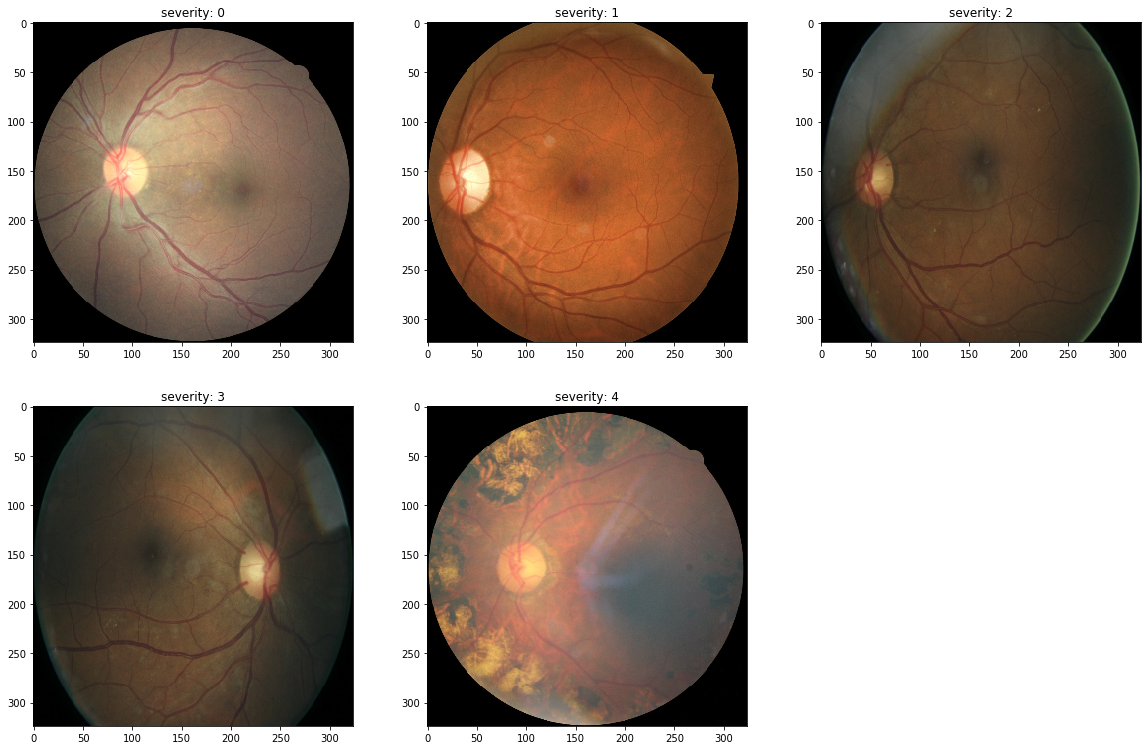

In [68]:
each_class_images_inds = get_each_class_image()
plt.figure(figsize=(20,20)),
step = 0
for i in range(5):
    plt.subplot(330 + 1 + step)
    img_ind = each_class_images_inds[i]
    img = cv2.resize(images[img_ind], (324, 324))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    plt.title("severity: " + str(labels[img_ind]))
    step +=1

#### After Ben Gram preprocessing

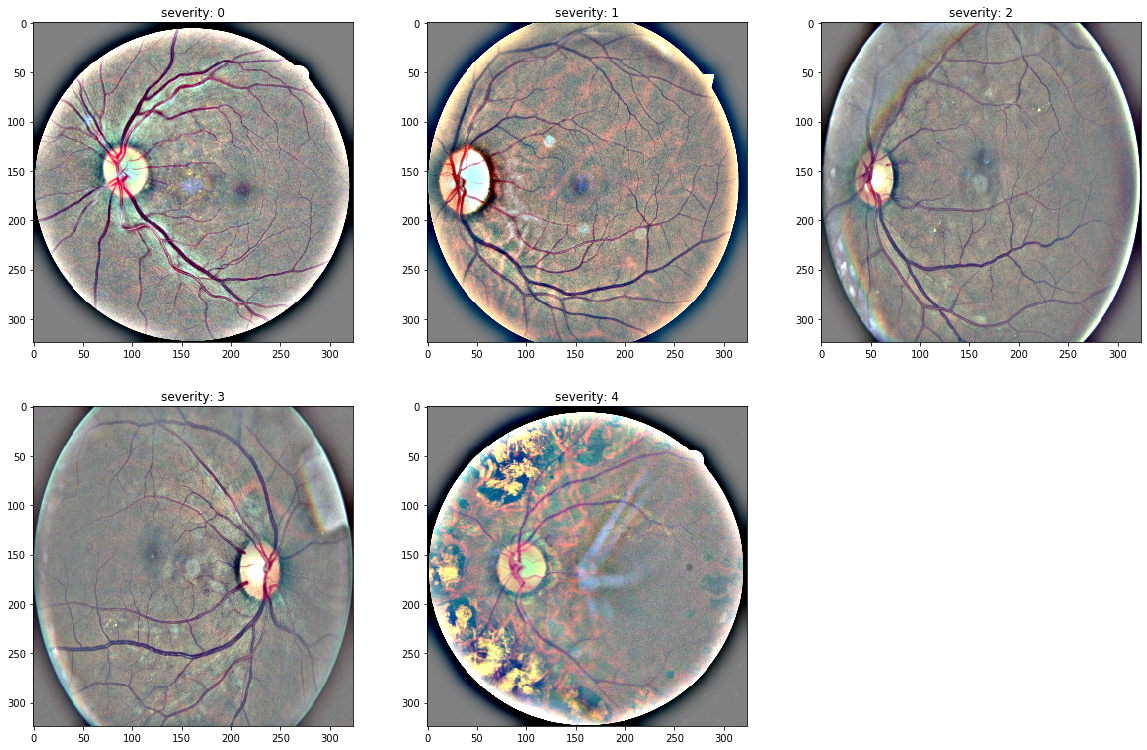

In [69]:
plt.figure(figsize=(20,20)),
for i in range(5):
    plt.subplot(330 + 1 + i)
    img_ind = each_class_images_inds[i]
    img = preprocess_image_ben_grams(images[img_ind], IMG_WIDTH=324, IMG_HEIGHT=324)
    show_image(img) 
    plt.title("severity: " + str(labels[img_ind]))

### split on 60/20/20 - train/test/val

In [70]:
x_train, x_test, y_train, y_test = train_test_split(
     images, multi_labels, test_size=0.33, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(
    images, multi_labels, test_size=0.4, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)

In [71]:
n = len(labels)
print("train shape ", x_train.shape)
print("train labels shape ", y_train.shape)
print("percentage of all {} pictures: ".format(n), round(x_train.shape[0]/n, 2)*100, "% \n")

print("validation shape ", x_val.shape)
print("validation labels shape ", y_val.shape)
print("percentage of all {} pictures: ".format(n), round(x_val.shape[0]/n, 2)*100, "% \n")

print("test shape ", x_test.shape)
print("test labels shape ", y_test.shape)
print("percentage of all {} pictures: ".format(n), round(x_test.shape[0]/n, 2)*100, "%")

train shape  (2124,)
train labels shape  (2124, 5)
percentage of all 3540 pictures:  60.0 % 

validation shape  (708,)
validation labels shape  (708, 5)
percentage of all 3540 pictures:  20.0 % 

test shape  (708,)
test labels shape  (708, 5)
percentage of all 3540 pictures:  20.0 %


### Create a callback for Kappa score. 
some errors stalus9, potim shota treba pominiatu

In [72]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

#         print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Building and training part

In [73]:
def create_datagen():
    return ImageDataGenerator(
        #zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        #fill_mode='constant',
        #cval=0.,  # value used for fill_mode = "constant"
        rotation_range=360,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=1 / 128
    )

def data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE, train_valid="train"):
    
    if train_valid == "train":
        prep_x_train = np.array([preprocess_image_ben_grams(i, IMG_WIDTH, IMG_HEIGHT) for i in x_train])
        return create_datagen().flow(prep_x_train, y_train, batch_size=BATCH_SIZE, shuffle=True, seed=2019)
    
    if train_valid == "valid":
        prep_x_val = np.array([preprocess_image_ben_grams(i, IMG_WIDTH, IMG_HEIGHT) for i in x_val])
        return create_datagen().flow(prep_x_val, y_val, batch_size=BATCH_SIZE, shuffle=True, seed=2019)

def build_model(transfer_learning_model, model_type):
    """
    transfer_learning_model - some pretrained architecture
    """
    model = Sequential()
    model.add(transfer_learning_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    
    if model_type == "effnet":
        model.add(layers.Dense(5, activation=elu))
        model.add(layers.Dense(1, activation="linear"))
        model.compile(loss='mse', 
                  metrics=['mse', 'acc'])
        
    if model_type == "densenet":
        model.add(layers.Dense(5, activation='relu'))
        model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
        
    if model_type == "resnet":
        model.add(layers.Dense(5, activation='relu'))
        model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    
    print(model.summary())
    return model

def run_model(model, train_generator, validation_generator, metric_type, appropriate_x_test, BATCH_SIZE):
#     with strategy.scope():
    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
    history = model.fit(
        x=train_generator,
        steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
        epochs=15,
        validation_data=validation_generator,
#         use_multiprocessing=True,
#         workers=200,
        validation_steps = x_val.shape[0] // BATCH_SIZE,
        callbacks=[es]
    )
    
    scores = model.evaluate(appropriate_x_test, y_test)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

In [74]:
kappa_metrics = Metrics()
mse_metrics =  "MSE()"

# DenseNet-121

In [75]:
# using DenseNet-121
#with strategy.scope():
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
# strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
# with strategy.scope():

densenet = DenseNet121(
        weights='data/densenet_weights/DenseNet-BC-121-32-no-top.h5',
        include_top=False,
        input_shape=(224,224,3)
    )

model_densenet = build_model(densenet, "densenet")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_12  (None, 1024)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________
None


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

train_generator = data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE=32, train_valid="train")
validation_generator = data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE=32, train_valid="valid")

In [ ]:
# with strategy.scope():
appropriate_x_test = np.array([preprocess_image_ben_grams(i, IMG_WIDTH, IMG_HEIGHT) for i in x_test])
run_model(model_densenet, train_generator, validation_generator, kappa_metrics, appropriate_x_test, BATCH_SIZE=32)

# EfficientNetB5

In [40]:
effnet = EfficientNetB5(weights='imagenet', include_top=False,
input_shape=(456,456, 3))


# Replace all Batch Normalization layers by Group Normalization layers
#for i, layer in enumerate(effnet.layers):
#    if "batch_normalization" in layer.name:
#        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)


model_effnet = build_model(effnet, "effnet")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 10245     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 28,523,771
Trainable params: 28,351,035
Non-trainable params: 172,736
_________________________________________________________________
None


In [41]:
IMG_WIDTH, IMG_HEIGHT = 456, 456

train_generator = data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE=32, train_valid="train")
validation_generator = data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE=32, train_valid="valid")

In [42]:
appropriate_x_test = np.array([preprocess_image_ben_grams(i, IMG_WIDTH, IMG_HEIGHT) for i in x_test])
run_model(model_effnet, train_generator, validation_generator, kappa_metrics, appropriate_x_test, BATCH_SIZE=32)

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 66 steps, validate for 22 steps
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_401037 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_421148 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/66 [..............................] - ETA: 2:50:39

ResourceExhaustedError:  OOM when allocating tensor with shape[32,240,114,114] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_7/efficientnet-b5/block2b_bn/FusedBatchNormV3 (defined at /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_421148]

Function call stack:
distributed_function


# ResNet50

In [32]:
resnet = ResNet50(weights="imagenet", include_top=False,
input_shape=(224,224, 3))

model_resnet = build_model(resnet, "resnet")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
None


In [33]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
train_generator = data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE=32, train_valid="train")
validation_generator = data_generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE=32, train_valid="valid")

In [34]:
appropriate_x_test = np.array([preprocess_image_ben_grams(i, IMG_WIDTH, IMG_HEIGHT) for i in x_test])
run_model(model_resnet, train_generator, validation_generator, kappa_metrics, appropriate_x_test, BATCH_SIZE=32)

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 66 steps, validate for 22 steps
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Test loss: 4.650749796527927
Test accuracy: 1.0
